In [1]:
# Cell 0 — Setup (imports + auto-installer)

import sys, subprocess, importlib, os, math, random, json
from pathlib import Path
from typing import Tuple, List, Dict
from datetime import date

import numpy as np
from PIL import Image

def ensure(pkg_pypi: str, import_name: str):
    """
    Try to import 'import_name'; if it fails, pip-install 'pkg_pypi' into this kernel.
    Return the imported module.
    """
    try:
        return importlib.import_module(import_name)
    except ModuleNotFoundError:
        print(f"Installing {pkg_pypi} into this kernel...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", pkg_pypi])
        return importlib.import_module(import_name)

# Third-party deps
C     = ensure("colour-science", "colour")
yaml  = ensure("pyyaml", "yaml")
pd    = ensure("pandas", "pandas")
mpl   = ensure("matplotlib", "matplotlib"); import matplotlib.pyplot as plt
tiff  = ensure("tifffile", "tifffile")

# Colour utilities we rely on later cells
from colour.notation.munsell import munsell_colour_to_xyY
from colour.difference import delta_E_CIE2000

print("colour-science:", getattr(C, "__version__", "unknown"))


colour-science: 0.4.6


In [2]:
# Cell 1 — Load config & derive constants (self-contained; no baseline.yaml)

YAML_PATH = "/Users/kate/Documents/retina-model/configs/pilot_patch.yaml"

with open(YAML_PATH, "r") as f:
    cfg = yaml.safe_load(f)

# --- Paths ---
IN_ROOT = Path(cfg["mask_dir"])  # binary masks (object=black, bg=white)

# Resolve date-stamped output dir from template
template = cfg.get("out_dir_template")
date_fmt = cfg.get("date_format", "%Y-%m-%d")
if template:
    today_str = date.today().strftime(date_fmt)
    OUT_ROOT = Path(template.format(date=today_str))
else:
    # fallback if someone manually sets out_dir instead of template
    OUT_ROOT = Path(cfg["out_dir"])
OUT_ROOT.mkdir(parents=True, exist_ok=True)

MANIFEST_SUBDIR = cfg.get("manifest_dir", "manifests")
(OUT_ROOT / MANIFEST_SUBDIR).mkdir(parents=True, exist_ok=True)

# --- Core setup ---
SEED = int(cfg.get("seed", 1234))
random.seed(SEED); np.random.seed(SEED)

SPLITS = dict(cfg["splits"])                 # {'train': 200, 'val': 50, 'test': 50}
IMG_H, IMG_W = cfg.get("img_size", [512, 512])

# --- Geometry (baked in) ---
S_MIN, S_MAX       = map(int,   cfg["object_max_dim_px"])   # range for chosen_max_dim_px
ROT_MIN, ROT_MAX   = map(float, cfg["rotation_deg"])
T_MIN, T_MAX       = map(int,   cfg["translation_px"])
BORDER             = int(cfg["border_px"])
APPEAR_MODE        = cfg.get("appearance_match_mode", "direct")

# --- Background (neutral gray) ---
FIXED_BG_LAB = np.array(cfg["background_lab"], dtype=float)
FORCE_NEUTRAL_BG = bool(cfg.get("force_neutral_background", True))

# --- Illumination rules ---
illum = cfg["illumination"]
INIT_COLORED        = bool(illum.get("initial_colored", True))
CANDS_WHITE_ONLY    = bool(illum.get("candidates_white_only", True))
WHITE_NAME          = illum.get("white_name", "D65")

tint_spec = illum.get("tint_lab_sampling", {})
TINT_MODE = tint_spec.get("mode", "uniform_ab")
TINT_L    = float(tint_spec.get("L", 60.0))
A_RANGE   = tuple(tint_spec.get("a_range", [-20.0, 20.0]))
B_RANGE   = tuple(tint_spec.get("b_range", [-20.0, 20.0]))

# --- Candidate write-time naming (fixed order, per your spec) ---
cand_cfg = cfg["candidates"]
KEEP_FIXED_ORDER = bool(cand_cfg.get("keep_fixed_order", True))
WRITE_NAMES      = list(cand_cfg.get("write_names", ["candT", "candF"]))
assert WRITE_NAMES == ["candT", "candF"], "YAML must specify write_names: ['candT','candF']"

# --- Object colour selection ---
objc = cfg["object_colour"]
OBJ_SOURCE        = objc.get("source", "munsell")
ALLOW_ALL_VALID   = bool(objc.get("allow_all_valid", True))

# --- Sampling / gamut policy ---
MAX_ATTEMPTS  = int(cfg.get("max_attempts", 100))
SHUFFLE_TINTS = bool(cfg.get("shuffle_tints", True))
RESAMPLE_OBJ  = bool(cfg.get("resample_object", True))
SKIP_IF_FAIL  = bool(cfg.get("skip_trial_if_fail", True))

# --- Outputs ---
outc = cfg["output"]
SAVE_PNG          = bool(outc.get("save_png", True))
SAVE_TIFF_XYZ     = bool(outc.get("save_tiff_xyz", True))
SAVE_NPZ_COLOURS  = bool(outc.get("save_npz_colours", True))
SAVE_MAT          = bool(outc.get("save_mat", False))
WRITE_TRIAL_JSON  = bool(outc.get("write_trial_json", True))

# --- Manifest schema ---
mani = cfg["manifest"]
WRITE_TRIALS_CSV = bool(mani.get("write_trials_csv", True))
MANIFEST_NAME    = mani.get("filename", "trials.csv")
MANIFEST_COLS    = list(mani.get("columns", []))

# enforce your recent rename
assert "chosen_max_dim_px" in MANIFEST_COLS, \
    "Manifest columns must include 'chosen_max_dim_px' (was 'target_max_dim')."

DW = mani.get("dominant_wavelengths", {})
DW_COMPUTE   = bool(DW.get("compute", True))
DW_REF_WHITE = DW.get("reference_white", "D65")
DW_FIELDS    = list(DW.get("fields", []))
DW_ON_FAIL   = DW.get("on_failure", "NaN")

# --- Mini chip set ---
chips = cfg.get("chips_mini_set", {})
CHIPS_ENABLED   = bool(chips.get("enabled", True))
CHIPS_COUNT     = int(chips.get("count", 20))
CHIPS_SAVE_DIR  = chips.get("save_dir", "chips")
CHIPS_TIFF_SFX  = chips.get("tiff_suffix", "_XYZ.tiff")
CHIPS_CSV_NAME  = chips.get("csv_name", "chips_manifest.csv")
CHIPS_FIELDS    = list(chips.get("fields_in_csv", ["image_size","obj_munsell","file_path","wavelength"]))

# --- Summary print (quick sanity) ---
print("Loaded config:", YAML_PATH)
print({
    "mask_dir": str(IN_ROOT),
    "out_dir": str(OUT_ROOT),
    "img_size": (IMG_H, IMG_W),
    "splits": SPLITS,
    "geometry": {"object_max_dim_px": (S_MIN, S_MAX), "rotation_deg": (ROT_MIN, ROT_MAX), "translation_px": (T_MIN, T_MAX)},
    "background_Lab": FIXED_BG_LAB.tolist(),
    "illumination": {"initial_colored": INIT_COLORED, "candidates_white_only": CANDS_WHITE_ONLY, "tint_mode": TINT_MODE, "L": TINT_L, "a_range": A_RANGE, "b_range": B_RANGE},
    "write_names": WRITE_NAMES,
    "manifest_cols_includes_chosen_max_dim_px": ("chosen_max_dim_px" in MANIFEST_COLS),
})


Loaded config: /Users/kate/Documents/retina-model/configs/pilot_patch.yaml
{'mask_dir': '/Users/kate/Documents/retina-model/Imageset_originalbw/original-bw-images/apples', 'out_dir': '/Users/kate/Documents/retina-model/2025-11-13_pilot_patch', 'img_size': (512, 512), 'splits': {'train': 200, 'val': 50, 'test': 50}, 'geometry': {'object_max_dim_px': (360, 460), 'rotation_deg': (-60.0, 60.0), 'translation_px': (3, 15)}, 'background_Lab': [60.0, 0.0, 0.0], 'illumination': {'initial_colored': True, 'candidates_white_only': True, 'tint_mode': 'uniform_ab', 'L': 60.0, 'a_range': (-20.0, 20.0), 'b_range': (-20.0, 20.0)}, 'write_names': ['candT', 'candF'], 'manifest_cols_includes_chosen_max_dim_px': True}


In [3]:
# Cell 2 — Build/validate the Munsell pool we'll sample object colours from.
# (Start from the canonical 1600 chromatic grid and keep only codes the
#  'colour-science' library can convert. Typically ~1587 remain.)

HUE_FAMILIES = ['R','YR','Y','GY','G','BG','B','PB','P','RP']
HUE_STEPS    = [2.5, 5, 7.5, 10]
VALUES       = list(range(2, 10))     # 2..9
CHROMAS      = [2, 4, 6, 8, 10]       # chromatic (no /0 here)

def canonical_chromatics() -> List[str]:
    return [f"{hs}{fam} {V}/{Cc}"
            for fam in HUE_FAMILIES
            for hs in HUE_STEPS
            for V in VALUES
            for Cc in CHROMAS]

def is_valid_munsell(code: str) -> bool:
    try:
        xyY = munsell_colour_to_xyY(code)
        arr = np.asarray(xyY, float)
        return arr.shape == (3,) and np.all(np.isfinite(arr))
    except Exception:
        return False

codes_1600 = canonical_chromatics()
chips_full  = [c for c in codes_1600 if is_valid_munsell(c)]
print(f"Validated chromatic chips (full): {len(chips_full)}  (nominal 1600; typical ~1587)")


Validated chromatic chips (full): 1587  (nominal 1600; typical ~1587)


In [4]:
# Cell 3 — Colour utilities, uniform-ab tint sampler, gamut checks

# sRGB colour space with D65 white (used throughout)
RGB_CS = C.RGB_COLOURSPACES["sRGB"]
ill_xy = np.array(RGB_CS.whitepoint, float)  # xy whitepoint for sRGB (D65)

# -- Basic conversions --
def XYZ_to_Lab(XYZ: np.ndarray) -> np.ndarray:
    return C.XYZ_to_Lab(np.asarray(XYZ, float), RGB_CS.whitepoint)

def Lab_to_XYZ(Lab: np.ndarray) -> np.ndarray:
    return C.Lab_to_XYZ(np.asarray(Lab, float), RGB_CS.whitepoint)

def XYZ_to_rgb_linear(XYZ: np.ndarray) -> np.ndarray:
    # Note: Colour 0.4.x signature → pass colourspace + whitepoint + CAT; no encoding
    return C.XYZ_to_RGB(np.asarray(XYZ, float), RGB_CS, ill_xy, "CAT02", apply_cctf_encoding=False)

def rgb_linear_to_XYZ(RGB_lin: np.ndarray) -> np.ndarray:
    return C.RGB_to_XYZ(np.asarray(RGB_lin, float), RGB_CS, ill_xy, "CAT02", apply_cctf_decoding=False)

def encode_sRGB(RGB_lin: np.ndarray) -> np.ndarray:
    # linear → display sRGB (gamma-encoded), still float [0..1]
    return RGB_CS.cctf_encoding(np.asarray(RGB_lin, float))

def deltaE00(Lab1, Lab2) -> float:
    return float(delta_E_CIE2000(np.asarray(Lab1, float), np.asarray(Lab2, float)))

def munsell_to_XYZ(code: str) -> np.ndarray:
    xyY = np.array(munsell_colour_to_xyY(code), dtype=float)
    return C.xyY_to_XYZ(xyY)

# -- Lighting model: uniform "chromatic light" via per-channel gains in linear sRGB --
NEUTRAL_LAB = np.array([TINT_L, 0.0, 0.0], float)  # neutral white (L*, a*, b*) for centre of tint sampling

def lighting_multiplier_linear_sRGB(tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Compute per-channel multipliers k so that the neutral white (neutral_Lab)
    maps to the tinted white (tint_Lab) in linear sRGB:
      k = RGB_lin(tinted_white) / RGB_lin(neutral_white)
    """
    RGBw_neutral = XYZ_to_rgb_linear(Lab_to_XYZ(neutral_Lab))
    RGBw_tint    = XYZ_to_rgb_linear(Lab_to_XYZ(tint_Lab))
    eps = 1e-8
    return (RGBw_tint + eps) / (RGBw_neutral + eps)

def apply_uniform_lighting_linear_sRGB(XYZ_img: np.ndarray, tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Apply uniform "lighting" to an XYZ image in linear sRGB and return linear sRGB.
    """
    RGB_lin = XYZ_to_rgb_linear(XYZ_img)
    k = lighting_multiplier_linear_sRGB(tint_Lab, neutral_Lab)
    return RGB_lin * k

# -- Tint sampler (uniform_ab per YAML) --
def sample_tint_lab() -> np.ndarray:
    """
    Sample a tint Lab = [TINT_L, a*, b*] with a* and b* uniform in configured ranges.
    """
    a = np.random.uniform(A_RANGE[0], A_RANGE[1])
    b = np.random.uniform(B_RANGE[0], B_RANGE[1])
    return np.array([TINT_L, a, b], float)

# -- Dataset-wide background (pre-tint) in XYZ and linear RGB (under D65) --
XYZ_BG_GRAY_D65  = Lab_to_XYZ(FIXED_BG_LAB)
RGB_BG_GRAY_LIN  = XYZ_to_rgb_linear(XYZ_BG_GRAY_D65)

# -- Gamut tests --
def in_gamut_lin(rgb_lin: np.ndarray) -> bool:
    """True if ALL components in rgb_lin are within [0, 1]."""
    m = float(np.min(rgb_lin)); M = float(np.max(rgb_lin))
    return (m >= 0.0) and (M <= 1.0)

def will_initial_clip(RGB_obj_lin_D65: np.ndarray, k: np.ndarray) -> bool:
    """
    Given object (under D65) linear RGB and lighting multiplier k,
    return True if either the object-after-tint OR the background-after-tint clips.
    """
    obj_lit = RGB_obj_lin_D65 * k
    bg_lit  = RGB_BG_GRAY_LIN * k
    return (not in_gamut_lin(obj_lit)) or (not in_gamut_lin(bg_lit))

def will_candidates_clip(RGB_obj_lin_D65: np.ndarray, Lab_obj_post_init: np.ndarray) -> bool:
    """
    For candidates under D65:
      - candT uses object-pre (under D65) → check its linear RGB.
      - candF uses object-post-init as pre under D65 → convert Lab to linear RGB and check.
      - Background is the dataset gray under D65 → check once (static).
    """
    if not in_gamut_lin(RGB_obj_lin_D65):
        return True
    if not in_gamut_lin(RGB_BG_GRAY_LIN):
        return True
    # candF object (appearance-match under D65)
    RGB_F_lin = XYZ_to_rgb_linear(Lab_to_XYZ(Lab_obj_post_init))
    if not in_gamut_lin(RGB_F_lin):
        return True
    return False


In [5]:
# Cell 4 — Turn binary PNGs into boolean masks and apply one geometry transform
# (scale, rotate, translate) shared by all 3 images in a trial.

def load_binary_mask(path: Path, thresh: int = 128) -> np.ndarray:
    """
    Load an RGB PNG where the object is black and the background is white.
    Return a boolean mask: True for object pixels.
    """
    arr = np.asarray(Image.open(path).convert("RGB"), dtype=np.uint8)
    gray = arr.mean(axis=2)
    return (gray < thresh)

def bbox_from_mask(M: np.ndarray):
    ys, xs = np.where(M)
    if xs.size == 0: return None
    return xs.min(), ys.min(), xs.max(), ys.max()

def center_paste(canvas_hw: Tuple[int,int], patch: np.ndarray) -> np.ndarray:
    H, W = canvas_hw
    ph, pw = patch.shape
    out = np.zeros((H, W), dtype=bool)
    y0 = (H - ph) // 2
    x0 = (W - pw) // 2
    out[y0:y0+ph, x0:x0+pw] = patch
    return out

def scale_mask_to_maxdim(M: np.ndarray, target_max: int) -> np.ndarray:
    bb = bbox_from_mask(M); assert bb is not None, "Empty mask!"
    x0, y0, x1, y1 = bb
    obj = M[y0:y1+1, x0:x1+1]
    h, w = obj.shape
    scale = target_max / max(h, w)
    new_h = max(1, int(round(h * scale)))
    new_w = max(1, int(round(w * scale)))
    obj_res = Image.fromarray((obj.astype(np.uint8) * 255)).resize((new_w, new_h), Image.NEAREST)
    obj_res = (np.asarray(obj_res, np.uint8) > 0)
    return center_paste((IMG_H, IMG_W), obj_res)

def rotate_mask_keep(M: np.ndarray, deg: float) -> np.ndarray:
    img = Image.fromarray((M.astype(np.uint8) * 255))
    big = img.rotate(deg, resample=Image.NEAREST, expand=True, fillcolor=0)
    big_np = (np.asarray(big, np.uint8) > 0)
    H, W = big_np.shape
    y0 = max(0, (H - IMG_H) // 2); x0 = max(0, (W - IMG_W) // 2)
    crop = big_np[y0:y0+IMG_H, x0:x0+IMG_W]
    out = np.zeros((IMG_H, IMG_W), bool)
    out[:crop.shape[0], :crop.shape[1]] = crop
    return out

def translate_mask(M: np.ndarray, dx: int, dy: int) -> np.ndarray:
    out = np.zeros_like(M)
    H, W = M.shape
    x0 = max(0, dx); y0 = max(0, dy)
    x1 = min(W, W + dx); y1 = min(H, H + dy)
    sx0 = max(0, -dx); sy0 = max(0, -dy)
    sx1 = sx0 + (x1 - x0); sy1 = sy0 + (y1 - y0)
    out[y0:y1, x0:x1] = M[sy0:sy1, sx0:sx1]
    return out

def min_margin(M: np.ndarray) -> int:
    ys, xs = np.where(M)
    if xs.size == 0: return 0
    return int(min(xs.min(), IMG_W - 1 - xs.max(), ys.min(), IMG_H - 1 - ys.max()))

def sample_angle_and_translate(M_scaled: np.ndarray) -> Tuple[float, int, int, np.ndarray]:
    """
    Randomly rotate then translate until the object stays ≥ BORDER px from edges.
    Up to 200 tries; if it fails, consider relaxing YAML geometry ranges.
    """
    for _ in range(200):
        ang = random.uniform(ROT_MIN, ROT_MAX)
        Mr = rotate_mask_keep(M_scaled, ang)
        if min_margin(Mr) >= BORDER:
            r = random.randint(T_MIN, T_MAX)
            theta = random.uniform(0, 2*math.pi)
            dx = int(round(r * math.cos(theta)))
            dy = int(round(r * math.sin(theta)))
            Mt = translate_mask(Mr, dx, dy)
            if min_margin(Mt) >= BORDER:
                return ang, dx, dy, Mt
    raise RuntimeError("Could not satisfy border constraints with current geometry settings.")


In [6]:
# Cell 5 — Colour selection & resampling (uniform-ab tinting; no exposure scaling)

def build_XYZ_from_mask(M: np.ndarray, XYZ_obj: np.ndarray, XYZ_bg: np.ndarray) -> np.ndarray:
    """
    Construct an XYZ image with two solid colours:
      - object pixels: XYZ_obj
      - background pixels: XYZ_bg
    """
    H, W = M.shape
    out = np.empty((H, W, 3), float)
    out[M]  = XYZ_obj
    out[~M] = XYZ_bg
    return out

def rgb_lin_to_u8(RGB_lin: np.ndarray) -> np.ndarray:
    """Encode linear sRGB to display sRGB and quantize to uint8 (0..255)."""
    RGB_disp = np.clip(encode_sRGB(np.clip(RGB_lin, 0.0, 1.0)), 0.0, 1.0)
    return (RGB_disp * 255.0 + 0.5).astype(np.uint8)

def choose_tint_order(n_samples: int = 32) -> List[np.ndarray]:
    """
    New semantics: draw 'n_samples' random tints using uniform a*/b* ranges at fixed L* (TINT_L).
    Kept as a list-returning function to minimize changes downstream.
    """
    return [sample_tint_lab() for _ in range(n_samples)]

def pick_object_and_tint_with_resampling() -> Dict:
    """
    Find (object chip, tint) so that:
      - INITIAL (object + BG) AFTER tint is in-gamut (linear sRGB ∈ [0,1], no scaling).
      - CANDIDATES (under D65) are in-gamut:
          candT uses object-pre; candF uses object-post-init as its pre.
      - (Optional ΔE guard removed for simplicity in this pilot.)
    Strategy:
      - Draw an object from the validated Munsell pool.
      - Try a batch of random tints from choose_tint_order().
      - If all tints fail, draw a new object (if allowed) and retry.
      - Cap attempts at MAX_ATTEMPTS; optionally skip trial if exhausted.
    Returns:
      dict with 'ok' flag, selected codes/colours, the lighting multiplier k, Lab post for object,
      counters (attempts_total/tint/object), and background Lab/XYZ.
    """
    attempts_total = 0
    attempts_tint  = 0
    attempts_obj   = 0

    # Background under D65 (fixed for the dataset)
    Lab_bg_pre = FIXED_BG_LAB
    XYZ_bg_pre = XYZ_BG_GRAY_D65
    RGB_bg_lin = RGB_BG_GRAY_LIN
    assert in_gamut_lin(RGB_bg_lin), "Fixed background gray (D65) is out of sRGB gamut; adjust YAML."

    while attempts_total < MAX_ATTEMPTS:
        attempts_total += 1
        attempts_obj   += 1

        # 1) Draw an object chip from the validated pool
        obj_code = random.choice(chips_full)
        XYZ_obj_pre = munsell_to_XYZ(obj_code)      # D65-referred
        Lab_obj_pre = XYZ_to_Lab(XYZ_obj_pre)

        # Early reject if object under D65 is already out-of-gamut for candidates (candT)
        RGB_obj_lin_D65 = XYZ_to_rgb_linear(XYZ_obj_pre)
        if not in_gamut_lin(RGB_obj_lin_D65):
            continue

        # 2) Try a batch of randomly sampled tints
        for tint_Lab in choose_tint_order():
            attempts_tint += 1

            # Lighting multipliers for linear sRGB (uniform lighting)
            k = lighting_multiplier_linear_sRGB(tint_Lab, NEUTRAL_LAB)

            # INITIAL: tint applies to object & background → both must stay in gamut
            if will_initial_clip(RGB_obj_lin_D65, k):
                continue

            # Compute object post-tint Lab (for appearance-match), from linear RGB after lighting
            Lab_obj_post_init = XYZ_to_Lab(rgb_linear_to_XYZ(RGB_obj_lin_D65 * k))

            # CANDIDATES under D65 must be in-gamut:
            #   candT uses obj_pre; candF uses obj_post_init
            if will_candidates_clip(RGB_obj_lin_D65, Lab_obj_post_init):
                continue

            # Success: this (object, tint) is valid with no scaling
            return dict(
                ok=True,
                # object (pre-tint, under D65)
                obj_code=obj_code,
                XYZ_obj_pre=XYZ_obj_pre,
                Lab_obj_pre=Lab_obj_pre,
                RGB_obj_lin_D65=RGB_obj_lin_D65,
                # background (pre-tint, under D65)
                XYZ_bg_pre=XYZ_bg_pre,
                Lab_bg_pre=Lab_bg_pre,
                # lighting
                tint_Lab=tint_Lab,
                k=k,
                # object post-tint (for initial, and for candF under D65)
                Lab_obj_post_init=Lab_obj_post_init,
                # counters
                attempts_total=attempts_total,
                attempts_tint=attempts_tint,
                attempts_obj=attempts_obj,
            )

        # If no tint worked for this object, optionally draw a new object
        if not RESAMPLE_OBJ:
            break  # give up—resampling object is disabled

    # Exhausted attempts
    if SKIP_IF_FAIL:
        return dict(ok=False, skipped=True, reason="resample_exhausted",
                    attempts_total=attempts_total, attempts_tint=attempts_tint, attempts_obj=attempts_obj)
    raise RuntimeError("Could not find a valid (object, tint) within the resample limits.")


In [7]:
# Quick smoke test for Cells 4–5 (run after 0–5)

# 1) pick a mask and do geometry
mask_paths = sorted(IN_ROOT.glob("*.png"))
assert mask_paths, f"No PNG masks found in {IN_ROOT}"
mp = random.choice(mask_paths)

M0 = load_binary_mask(mp)
target_max = random.randint(S_MIN, S_MAX)
M_scaled = scale_mask_to_maxdim(M0, target_max)
ang, dx, dy, M_geom = sample_angle_and_translate(M_scaled)

# 2) pick object+tint with resampling
choice = pick_object_and_tint_with_resampling()

print("Mask:", mp.name)
print("chosen_max_dim_px:", target_max, "| angle:", f"{ang:.1f}", "| dx/dy:", (dx, dy))
print("Object Munsell:", choice.get("obj_code"))
print("Tint Lab:", np.round(choice.get("tint_Lab"), 3).tolist())
print("Attempts (total / tint / object):",
      choice.get("attempts_total"), "/", choice.get("attempts_tint"), "/", choice.get("attempts_obj"))
print("OK:", choice.get("ok", False), "| Skipped:", choice.get("skipped", 0))


Mask: apple2.png
chosen_max_dim_px: 374 | angle: -59.1 | dx/dy: (-13, -7)
Object Munsell: 7.5P 7/8
Tint Lab: [60.0, -12.339, 4.884]
Attempts (total / tint / object): 1 / 1 / 1
OK: True | Skipped: 0


In [8]:
# Cell 6 — Build ONE trial; save PNG/TIFF/NPZ/JSON; return manifest row

# ---- small I/O helpers ----
def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True)

def save_png(arr_u8: np.ndarray, path: Path):
    Image.fromarray(arr_u8).save(path, "PNG")

def save_xyz_tiff(path: Path, XYZ: np.ndarray):
    """Save float32 XYZ as a 3-channel TIFF (D65-referred)."""
    assert XYZ.dtype in (np.float32, np.float64) and XYZ.ndim == 3 and XYZ.shape[2] == 3
    tiff.imwrite(str(path), XYZ.astype(np.float32), dtype=np.float32)

def save_lab_xyz_npz(path: Path, **arrays_and_meta):
    """Save Lab/XYZ arrays (float32) plus small metadata as a compressed NPZ."""
    pack = {}
    for k, v in arrays_and_meta.items():
        if isinstance(v, np.ndarray) and v.dtype != np.float32:
            pack[k] = v.astype(np.float32)
        else:
            pack[k] = v
    np.savez_compressed(path, **pack)

# ---- dominant wavelength (best-effort) ----
try:
    # API location differs by colour-science version; try both
    try:
        from colour.colorimetry import dominant_wavelength as _dominant_wavelength
    except Exception:
        from colour.metrics import dominant_wavelength as _dominant_wavelength
except Exception:
    _dominant_wavelength = None

def estimate_dw_from_Lab(Lab: np.ndarray) -> float:
    """Return dominant wavelength in nm (or np.nan if undefined/unavailable)."""
    if _dominant_wavelength is None:
        return float("nan")
    try:
        xy = C.Lab_to_xy(np.asarray(Lab, float), RGB_CS.whitepoint)
        wl, purity = _dominant_wavelength(xy, ill_xy)  # may raise or return None if outside locus
        return float(wl) if wl is not None else float("nan")
    except Exception:
        return float("nan")

def pix_rgb_u8_from_lab(Lab):
    rgb_lin = XYZ_to_rgb_linear(Lab_to_XYZ(Lab))
    return (encode_sRGB(np.clip(rgb_lin, 0, 1)) * 255 + 0.5).astype(np.uint8)

def one_trial(
    mask_paths: List[Path], split: str, trial_id: int, out_split_dir: Path,
) -> Dict:
    # --- Geometry shared across the triplet ---
    mask_path = random.choice(mask_paths)
    M0 = load_binary_mask(mask_path)
    chosen_max = random.randint(S_MIN, S_MAX)
    M_scaled = scale_mask_to_maxdim(M0, chosen_max)
    ang, dx, dy, M_geom = sample_angle_and_translate(M_scaled)

    # --- Colour choices (with resampling for gamut) ---
    choice = pick_object_and_tint_with_resampling()
    if not choice.get("ok", False):
        # If we skip, return a minimal row (will be filtered out later)
        return {**choice, "split": split, "trial_id": trial_id, "skipped": 1}

    # Unpack selections
    obj_code          = choice["obj_code"]
    Lab_obj_pre       = choice["Lab_obj_pre"]
    XYZ_obj_pre       = choice["XYZ_obj_pre"]
    RGB_obj_lin_D65   = choice["RGB_obj_lin_D65"]
    tint_Lab          = choice["tint_Lab"]
    k                 = choice["k"]
    Lab_bg_pre        = choice["Lab_bg_pre"]
    XYZ_bg_pre        = choice["XYZ_bg_pre"]
    Lab_obj_post_init = choice["Lab_obj_post_init"]

    # --- INITIAL (tint applies to whole image) ---
    XYZ_init_pre = build_XYZ_from_mask(M_geom, XYZ_obj_pre, XYZ_bg_pre)
    RGB_init_lin = apply_uniform_lighting_linear_sRGB(XYZ_init_pre, tint_Lab, NEUTRAL_LAB).astype(np.float32)
    assert in_gamut_lin(RGB_init_lin), "Initial image out of gamut unexpectedly (after resampling)."
    XYZ_init_post = rgb_linear_to_XYZ(RGB_init_lin).astype(np.float32)
    Lab_init_post = XYZ_to_Lab(XYZ_init_post).astype(np.float32)

    # Swatch-level background after tint (for reporting)
    RGB_bg_post_lin = RGB_BG_GRAY_LIN * k
    Lab_bg_post     = XYZ_to_Lab(rgb_linear_to_XYZ(RGB_bg_post_lin)).astype(np.float32)

    # --- CANDIDATES (under D65, white-only) ---
    # candT: same surface (pre-illum) on gray
    XYZ_candT = build_XYZ_from_mask(M_geom, XYZ_obj_pre, XYZ_bg_pre).astype(np.float32)
    RGB_T_lin = XYZ_to_rgb_linear(XYZ_candT).astype(np.float32)
    assert in_gamut_lin(RGB_T_lin), "candT out of gamut unexpectedly."

    # candF: object's post-init appearance becomes its pre-illum colour
    XYZ_candF_obj = Lab_to_XYZ(Lab_obj_post_init)
    XYZ_candF = build_XYZ_from_mask(M_geom, XYZ_candF_obj, XYZ_bg_pre).astype(np.float32)
    RGB_F_lin = XYZ_to_rgb_linear(XYZ_candF).astype(np.float32)
    assert in_gamut_lin(RGB_F_lin), "candF out of gamut unexpectedly."

    # --- Encode PNGs (if requested) ---
    to_u8 = lambda RGB_lin: (encode_sRGB(np.clip(RGB_lin, 0, 1)) * 255 + 0.5).astype(np.uint8)
    init_u8, candT_u8, candF_u8 = to_u8(RGB_init_lin), to_u8(RGB_T_lin), to_u8(RGB_F_lin)

    # --- Save outputs ---
    tdir = out_split_dir / f"trial_{trial_id:06d}"
    ensure_dir(tdir)

    # Filenames are fixed and label-revealing BY DESIGN per your spec
    initial_path = candT_path = candF_path = ""
    if SAVE_PNG:
        save_png(init_u8, tdir / "initial.png")
        save_png(candT_u8, tdir / "candT.png")
        save_png(candF_u8, tdir / "candF.png")
        initial_path = str((tdir / "initial.png").relative_to(OUT_ROOT))
        candT_path   = str((tdir / "candT.png").relative_to(OUT_ROOT))
        candF_path   = str((tdir / "candF.png").relative_to(OUT_ROOT))

    if SAVE_TIFF_XYZ:
        save_xyz_tiff(tdir / "initial_XYZ.tiff", XYZ_init_post)
        save_xyz_tiff(tdir / "candT_XYZ.tiff",   XYZ_candT)
        save_xyz_tiff(tdir / "candF_XYZ.tiff",   XYZ_candF)

    if SAVE_NPZ_COLOURS:
        Lab_candT = XYZ_to_Lab(XYZ_candT).astype(np.float32)
        Lab_candF = XYZ_to_Lab(XYZ_candF).astype(np.float32)
        save_lab_xyz_npz(
            tdir / "colours.npz",
            XYZ_init=XYZ_init_post, XYZ_candT=XYZ_candT, XYZ_candF=XYZ_candF,
            Lab_init=Lab_init_post, Lab_candT=Lab_candT, Lab_candF=Lab_candF,
            meta_whitepoint="D65",
            meta_background_lab_pre=FIXED_BG_LAB.astype(np.float32),
            meta_tint_lab=tint_Lab.astype(np.float32),
            meta_appearance_match_mode="direct",
        )

    if WRITE_TRIAL_JSON:
        with open(tdir / "trial.json", "w") as f:
            json.dump({
                "split": split, "trial_id": trial_id,
                "geometry": {"chosen_max_dim_px": int(chosen_max), "rotation_deg": float(ang), "dx": int(dx), "dy": int(dy)},
                "object": {"munsell": obj_code},
                "illumination": {"tint_lab": [float(x) for x in tint_Lab], "neutral_Lab": [float(x) for x in NEUTRAL_LAB]},
            }, f, indent=2)

    # --- Manifest row ---
    # sRGB swatches (for viewer/checks)
    obj_pre_rgb   = pix_rgb_u8_from_lab(Lab_obj_pre)
    bg_pre_rgb    = pix_rgb_u8_from_lab(Lab_bg_pre)
    tint_rgb      = pix_rgb_u8_from_lab(tint_Lab)
    obj_post_rgb  = pix_rgb_u8_from_lab(Lab_obj_post_init)
    bg_post_rgb   = pix_rgb_u8_from_lab(Lab_bg_post)

    row = {
        "split": split, "trial_id": trial_id, "skipped": 0,
        "mask_file": mask_path.name,
        "image_size": f"{IMG_H}x{IMG_W}",
        "chosen_max_dim_px": int(chosen_max),
        "rotation_deg": float(ang), "dx": int(dx), "dy": int(dy),
        "obj_munsell": obj_code,
        "resample_attempts_total": choice["attempts_total"],
        "resample_attempts_tint":  choice["attempts_tint"],
        "resample_attempts_object": choice["attempts_obj"],
        "initial_path": initial_path,
        "candT_path":   candT_path,
        "candF_path":   candF_path,
        # Lab fields for analysis/viewer
        "tint_lab":          json.dumps([round(float(x), 5) for x in np.asarray(tint_Lab).ravel()]),
        "bg_lab_pre":        json.dumps([round(float(x), 5) for x in np.asarray(Lab_bg_pre).ravel()]),
        "obj_lab_pre":       json.dumps([round(float(x), 5) for x in np.asarray(Lab_obj_pre).ravel()]),
        "obj_lab_post_init": json.dumps([round(float(x), 5) for x in np.asarray(Lab_obj_post_init).ravel()]),
        "bg_lab_post_init":  json.dumps([round(float(x), 5) for x in np.asarray(Lab_bg_post).ravel()]),
        # sRGB bytes for viewer/sanity checks
        "obj_rgb_pre":          json.dumps(obj_pre_rgb.tolist()),
        "bg_rgb_pre":           json.dumps(bg_pre_rgb.tolist()),
        "tint_rgb":             json.dumps(tint_rgb.tolist()),
        "obj_rgb_post_init":    json.dumps(obj_post_rgb.tolist()),
        "bg_rgb_post_init":     json.dumps(bg_post_rgb.tolist()),
        "candT_obj_rgb":        json.dumps(obj_pre_rgb.tolist()),
        "candF_obj_rgb":        json.dumps(obj_post_rgb.tolist()),
        "cand_bg_rgb":          json.dumps(bg_pre_rgb.tolist()),
    }

    # Optional: dominant wavelengths into CSV as extra columns
    if DW_COMPUTE:
        dw_map = {
            "initial_obj_pre": estimate_dw_from_Lab(Lab_obj_pre),
            "initial_obj_post": estimate_dw_from_Lab(Lab_init_post.mean(axis=(0,1)) if Lab_init_post.ndim==3 else Lab_obj_post_init),  # fallback
            "candT_obj_pre": estimate_dw_from_Lab(Lab_obj_pre),
            "candF_obj_pre": estimate_dw_from_Lab(Lab_obj_post_init),
            "background": estimate_dw_from_Lab(Lab_bg_pre),
        }
        for k_dw, val in dw_map.items():
            row[f"{k_dw}_wavelength_nm"] = float(val)

    return row


In [9]:
# Cell 7 — Generate dataset across splits; write manifest; print summary

# Discover masks (flat folder of PNGs per your current setup)
mask_paths = sorted(IN_ROOT.glob("*.png"))
assert mask_paths, f"No PNG masks found in {IN_ROOT}"

rows = []
skipped = 0

for split in ["train", "val", "test"]:
    n = int(SPLITS[split])
    out_split_dir = OUT_ROOT / split
    out_split_dir.mkdir(parents=True, exist_ok=True)

    i = 1
    while i <= n:
        row = one_trial(mask_paths, split, i, out_split_dir)
        # If a trial was skipped, try again (same trial_id)
        if row.get("skipped", 0) == 1:
            skipped += 1
            continue
        rows.append(row)
        i += 1

# Write manifest CSV
manifest_dir = OUT_ROOT / MANIFEST_SUBDIR
manifest_dir.mkdir(parents=True, exist_ok=True)
csv_path = manifest_dir / "trials.csv"

if WRITE_TRIALS_CSV and rows:
    df = pd.DataFrame(rows)
    # Reorder columns to your schema first, then append any extras (e.g., *_wavelength_nm)
    base_cols = MANIFEST_COLS
    extra_cols = [c for c in df.columns if c not in base_cols]
    df = df[base_cols + extra_cols]
    df.to_csv(csv_path, index=False)

print(f"Wrote {len(rows)} trials: train={SPLITS['train']}, val={SPLITS['val']}, test={SPLITS['test']}")
print(f"Manifest: {csv_path}")
print(f"Skipped due to gamut: {skipped}")

# Quick resampling stats
if rows:
    import numpy as _np
    df = pd.DataFrame(rows)
    print("Resample attempts per kept trial (mean ± sd):",
          f"{df['resample_attempts_total'].mean():.2f} ± {df['resample_attempts_total'].std():.2f}")
    print("99th percentile:", _np.percentile(df['resample_attempts_total'], 99))


Wrote 300 trials: train=200, val=50, test=50
Manifest: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/manifests/trials.csv
Skipped due to gamut: 0
Resample attempts per kept trial (mean ± sd): 1.34 ± 0.63
99th percentile: 3.01


Manifest rows: 300 | Columns: 34
PNG existence — initial: True candT: True candF: True
Swatch consistency (candT=obj_pre & candF=obj_post & bg matches): 10/10 OK


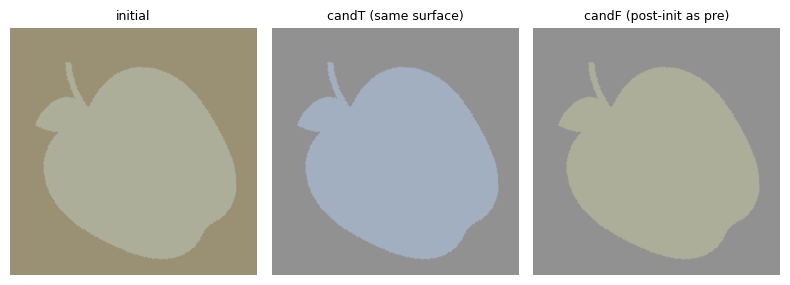

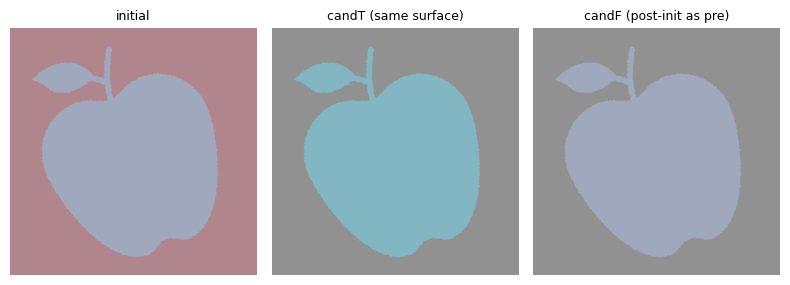

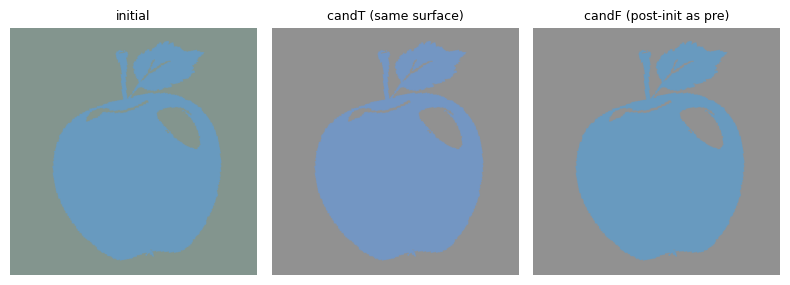

QA complete.


In [10]:
# Cell 8 — Post-gen QA: path integrity, field consistency, quick thumbnails

import json
import pandas as pd
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Locate manifest
csv_path = OUT_ROOT / MANIFEST_SUBDIR / MANIFEST_NAME
assert csv_path.exists(), f"Manifest missing: {csv_path}"
df = pd.read_csv(csv_path)
print("Manifest rows:", len(df), "| Columns:", len(df.columns))

# --- 1) Column presence (matches your schema)
required = set(MANIFEST_COLS)
missing = [c for c in required if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"
assert "chosen_max_dim_px" in df.columns

# --- 2) File existence checks (PNG outputs per your spec)
def _exists(rel):
    return (OUT_ROOT / rel).exists() if isinstance(rel, str) and rel else False

need_pngs = SAVE_PNG
if need_pngs:
    exists_initial = df["initial_path"].map(_exists).all()
    exists_candT   = df["candT_path"].map(_exists).all()
    exists_candF   = df["candF_path"].map(_exists).all()
    print("PNG existence — initial:", exists_initial, "candT:", exists_candT, "candF:", exists_candF)
    assert exists_initial and exists_candT and exists_candF, "Some PNG paths are missing on disk."

# --- 3) Logical consistency: swatch checks on a small sample
sample_df = df.sample(min(10, len(df)), random_state=0)
def as_arr(col):
    return np.array(json.loads(col), dtype=float)

ok_pairs = 0
for _, r in sample_df.iterrows():
    obj_pre_rgb   = as_arr(r["obj_rgb_pre"])
    obj_post_rgb  = as_arr(r["obj_rgb_post_init"])
    candT_rgb     = as_arr(r["candT_obj_rgb"])
    candF_rgb     = as_arr(r["candF_obj_rgb"])
    bg_pre_rgb    = as_arr(r["bg_rgb_pre"])
    cand_bg_rgb   = as_arr(r["cand_bg_rgb"])
    # candT should match obj_pre; candF should match obj_post; backgrounds should match
    ok = (np.allclose(candT_rgb, obj_pre_rgb, atol=2)
          and np.allclose(candF_rgb, obj_post_rgb, atol=2)
          and np.allclose(cand_bg_rgb, bg_pre_rgb, atol=2))
    ok_pairs += int(ok)
print(f"Swatch consistency (candT=obj_pre & candF=obj_post & bg matches): {ok_pairs}/{len(sample_df)} OK")

# --- 4) Quick thumbnails for 3 random trials
def show_triplet(row):
    ip = OUT_ROOT / row["initial_path"]
    tp = OUT_ROOT / row["candT_path"]
    fp = OUT_ROOT / row["candF_path"]
    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    for ax, p, title in zip(axes, [ip, tp, fp], ["initial", "candT (same surface)", "candF (post-init as pre)"]):
        ax.imshow(Image.open(p)); ax.set_title(title, fontsize=9); ax.axis("off")
    plt.tight_layout(); plt.show()

if need_pngs:
    for _, r in df.sample(3, random_state=1).iterrows():
        show_triplet(r)

print("QA complete.")


In [11]:
# Cell 9 — Mini Munsell chip set (+ CSV)

if not CHIPS_ENABLED:
    print("chips_mini_set: disabled in YAML — skipping.")
else:
    CHIPS_DIR = OUT_ROOT / CHIPS_SAVE_DIR
    CHIPS_DIR.mkdir(parents=True, exist_ok=True)

    rng = np.random.RandomState(SEED)
    pool = list(chips_full)
    if CHIPS_COUNT <= len(pool):
        sel = rng.choice(pool, size=CHIPS_COUNT, replace=False)
    else:
        sel = rng.choice(pool, size=CHIPS_COUNT, replace=True)

    def sanitize_munsell(code: str) -> str:
        # e.g., "2.5R 6/8" -> "2p5R_6-8"
        s = code.replace(" ", "_").replace("/", "-").replace(".", "p")
        return s

    rows = []
    for code in sel:
        XYZ = munsell_to_XYZ(code).astype(np.float32)
        Lab = XYZ_to_Lab(XYZ).astype(np.float32)
        patch_XYZ = np.tile(XYZ.reshape(1, 1, 3), (IMG_H, IMG_W, 1)).astype(np.float32)

        stem = sanitize_munsell(code) + CHIPS_TIFF_SFX  # suffix includes "_XYZ.tiff"
        fpath = CHIPS_DIR / stem
        tiff.imwrite(str(fpath), patch_XYZ, dtype=np.float32)

        # best-effort dominant wavelength (nm)
        wl = estimate_dw_from_Lab(Lab) if "estimate_dw_from_Lab" in globals() else float("nan")

        rows.append({
            "image_size": f"{IMG_H}x{IMG_W}",
            "obj_munsell": code,
            "file_path": str(fpath.relative_to(OUT_ROOT)),
            "wavelength": float(wl),
        })

    chips_csv = CHIPS_DIR / CHIPS_CSV_NAME
    pd.DataFrame(rows)[CHIPS_FIELDS].to_csv(chips_csv, index=False)

    print(f"Mini chip set written: {len(rows)} files")
    print("Folder:", CHIPS_DIR)
    print("CSV:", chips_csv)


Mini chip set written: 20 files
Folder: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/chips
CSV: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/chips/chips_manifest.csv


In [12]:
# Cell 10 — Final summary & handy paths

manifest_path = OUT_ROOT / MANIFEST_SUBDIR / MANIFEST_NAME
n_trials = None
if manifest_path.exists():
    try:
        n_trials = sum(pd.read_csv(manifest_path)["split"].value_counts().reindex(["train","val","test"], fill_value=0))
    except Exception:
        pass

print("=== Pilot Patch — Done ===")
print("Root:", OUT_ROOT)
print("Masks:", IN_ROOT)
print("Manifest:", manifest_path)
if n_trials is not None:
    print(f"Trials written (total): {int(n_trials)}  | splits -> {SPLITS}")
else:
    print("Trials written: see manifest above.")

chips_dir = OUT_ROOT / CHIPS_SAVE_DIR
chips_csv = chips_dir / CHIPS_CSV_NAME
if CHIPS_ENABLED and chips_csv.exists():
    try:
        n_chips = len(pd.read_csv(chips_csv))
        print(f"Mini chip set: {n_chips} files")
        print("Chips folder:", chips_dir)
        print("Chips CSV:", chips_csv)
    except Exception:
        print("Mini chip set present (CSV load issue).")
else:
    print("Mini chip set: none (disabled or not generated).")

print("All set. You can now feed these images into the ISETBio pipeline → mRGC responses.")


=== Pilot Patch — Done ===
Root: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch
Masks: /Users/kate/Documents/retina-model/Imageset_originalbw/original-bw-images/apples
Manifest: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/manifests/trials.csv
Trials written (total): 300  | splits -> {'train': 200, 'val': 50, 'test': 50}
Mini chip set: 20 files
Chips folder: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/chips
Chips CSV: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/chips/chips_manifest.csv
All set. You can now feed these images into the ISETBio pipeline → mRGC responses.
